In [2]:
#필요한 모듈 import
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

# from statsmodels.tsa.arima_model import ARIMA

### 1. Data Concat(2015~2022)

In [3]:
#전체 공공자전거 고장신고 데이터 불러오기
data = pd.read_csv("/Users/janghyun/Desktop/BDP/data/대여이력 정보/data/broken.csv")

In [50]:
#data 확인
data.head()

,자전거번호,등록일시,고장구분
0,SPB-00108,2015.12.4 7:41,체인
1,SPB-00210,2015.12.7 12:23,체인
2,SPB-00035,2015.12.9 17:07,기타
3,SPB-01024,2015.12.13 21:02,기타
4,SPB-01015,2015.12.28 10:12,기타


In [51]:
#결측치 확인
data.isnull().sum()

자전거번호    0
등록일시     0
고장구분     0
dtype: int64

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412797 entries, 0 to 412796
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   자전거번호   412797 non-null  object
 1   등록일시    412797 non-null  object
 2   고장구분    412797 non-null  object
dtypes: object(3)
memory usage: 9.4+ MB


In [4]:
#자전거번호 고유값별 count
num_value = data['자전거번호'].value_counts().to_frame()
num_value

,자전거번호
SPB-00001,197
SPB-11111,105
SPB-00003,104
SPB-00005,101
SPB-00008,101
...,...
SPB-58832,1
SPB-18888,1
SPB-23686,1
SPB-84890,1


In [5]:
#고장구분 고유값별 count
type_value = data['고장구분'].value_counts().to_frame()
type_value

,고장구분
기타,102417
체인,83406
타이어,71590
안장,64298
단말기,57286
페달,32920
파손,629
잠금장치 불량,251


### 2. Time Series Analysis(Entire Data)

In [6]:
#등록일시 type 변경
data["등록일시"]=pd.to_datetime(data['등록일시'].str.strip(), format="%Y-%m-%d %H:%M", errors='coerce')
data.head()

,자전거번호,등록일시,고장구분
0,SPB-00108,2015-12-04 07:41:00,체인
1,SPB-00210,2015-12-07 12:23:00,체인
2,SPB-00035,2015-12-09 17:07:00,기타
3,SPB-01024,2015-12-13 21:02:00,기타
4,SPB-01015,2015-12-28 10:12:00,기타


In [7]:
#분류 위해 등록일시 type 변경
data["등록일시"] = data["등록일시"].dt.date
data["등록일시"] = pd.to_datetime(data["등록일시"])

data.head()

,자전거번호,등록일시,고장구분
0,SPB-00108,2015-12-04,체인
1,SPB-00210,2015-12-07,체인
2,SPB-00035,2015-12-09,기타
3,SPB-01024,2015-12-13,기타
4,SPB-01015,2015-12-28,기타


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412797 entries, 0 to 412796
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   자전거번호   412797 non-null  object        
 1   등록일시    412797 non-null  datetime64[ns]
 2   고장구분    412797 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 9.4+ MB


In [9]:
#필요 column 추출 후, 등록일시로 index 전환
data_idx = data[["등록일시", "고장구분"]]
data_idx.set_index("등록일시", inplace=True)
data_idx.head()

,고장구분
등록일시,
2015-12-04,체인
2015-12-07,체인
2015-12-09,기타
2015-12-13,기타
2015-12-28,기타


In [10]:
#등록일시별로 groupby 후 고장구분 count => 같은 날짜, 다른 고장 구분 안합쳐짐
data_idx["c"]=data_idx.groupby("등록일시").고장구분.count()
data_idx.head()

/var/folders/qy/_42009_n085fc984bjdc5v580000gn/T/ipykernel_250/688686610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_idx["c"]=data_idx.groupby("등록일시").고장구분.count()


,고장구분,c
등록일시,,
2015-12-04,체인,1
2015-12-07,체인,1
2015-12-09,기타,1
2015-12-13,기타,1
2015-12-28,기타,1


In [11]:
#data/고장구분 고장신고 count df 생성
data_type = data_idx.groupby(["등록일시", "고장구분"]).c.sum().unstack()
data_type.head()

고장구분,기타,단말기,안장,잠금장치 불량,체인,타이어,파손,페달
등록일시,,,,,,,,
2015-12-04,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2015-12-07,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2015-12-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-13,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-28,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#결측치 제거
data_type = data_type.fillna(0)
data_type.head()

고장구분,기타,단말기,안장,잠금장치 불량,체인,타이어,파손,페달
등록일시,,,,,,,,
2015-12-04,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-12-07,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-12-09,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-12-13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-12-28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#date별 전체 고장 건수 합
data_type["sum"]  = data_type.sum(axis=1)
data_type.head()

고장구분,기타,단말기,안장,잠금장치 불량,체인,타이어,파손,페달,sum
등록일시,,,,,,,,,
2015-12-04,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2015-12-07,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2015-12-09,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-12-13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-12-28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
#float -> int 변경
data_type=data_type.astype(int)
data_type.head()

고장구분,기타,단말기,안장,잠금장치 불량,체인,타이어,파손,페달,sum
등록일시,,,,,,,,,
2015-12-04,0,0,0,0,1,0,0,0,1
2015-12-07,0,0,0,0,1,0,0,0,1
2015-12-09,1,0,0,0,0,0,0,0,1
2015-12-13,1,0,0,0,0,0,0,0,1
2015-12-28,1,0,0,0,0,0,0,0,1


### 2-1. Visualize

In [16]:
#전체 합만 가지고 있는 df 생성
data_sum = data_type["sum"]

<AxesSubplot: title={'center': 'ALL_SUM'}, xlabel='등록일시', ylabel='고장신고 건수'>

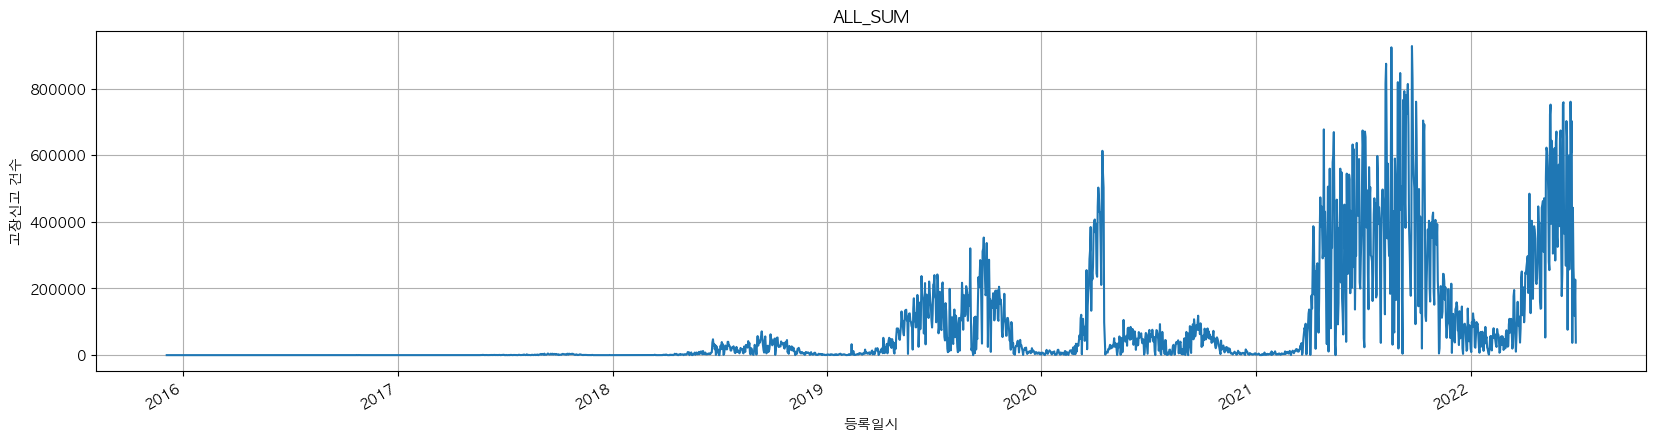

In [65]:
#전체 데이터 고장구분 sum 시각화
rc('font', family='AppleGothic')
plt.title("ALL_SUM")#데이터_고장구분
plt.xlabel("날짜")
plt.ylabel("고장신고 건수")
data_sum.plot(figsize=(20, 5), grid=True)

<AxesSubplot: title={'center': '2018.6-2022.6_SUM'}, xlabel='등록일시', ylabel='고장신고 건수'>

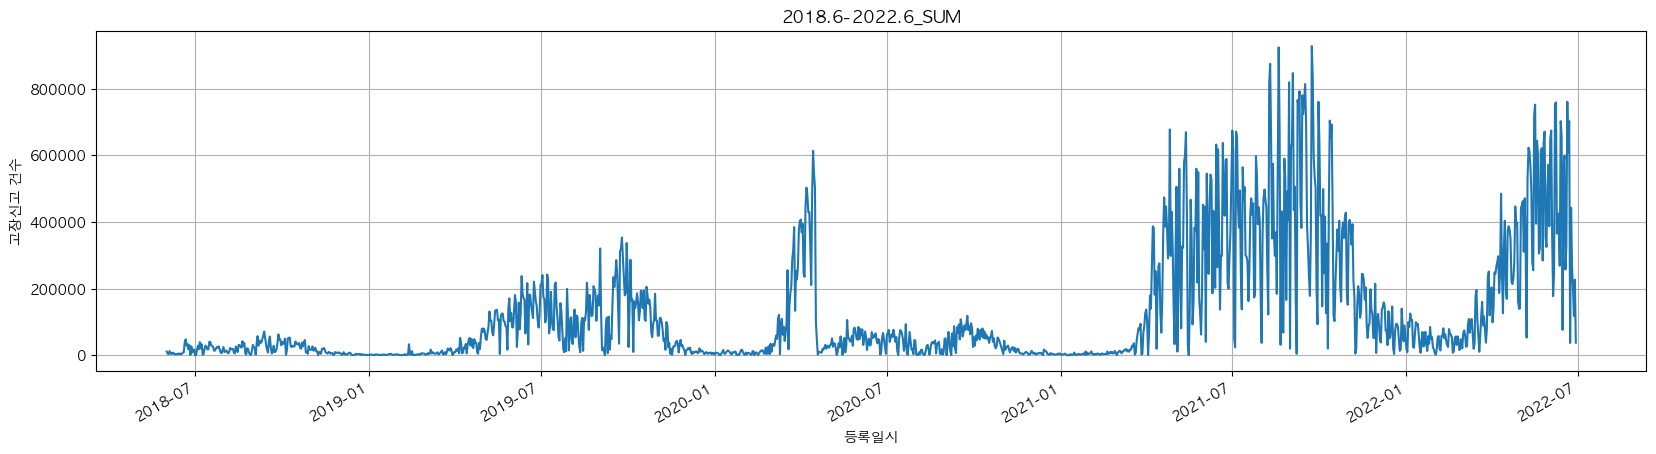

In [66]:
#고장신고가 증가하기 시작한 2018.6부터 전체 고장구분 sum 시각화
rc('font', family='AppleGothic')
plt.title("2018.6-2022.6_SUM")#데이터_고장구분
plt.xlabel("날짜")
plt.ylabel("고장신고 건수")
data_sum["2018-6":].plot(figsize=(20, 5), grid=True)

In [67]:
#더 자세한 확인을 위해 1년 단위로 시각화

<AxesSubplot: title={'center': '2018.6-2019.6_SUM'}, xlabel='등록일시', ylabel='고장신고 건수'>

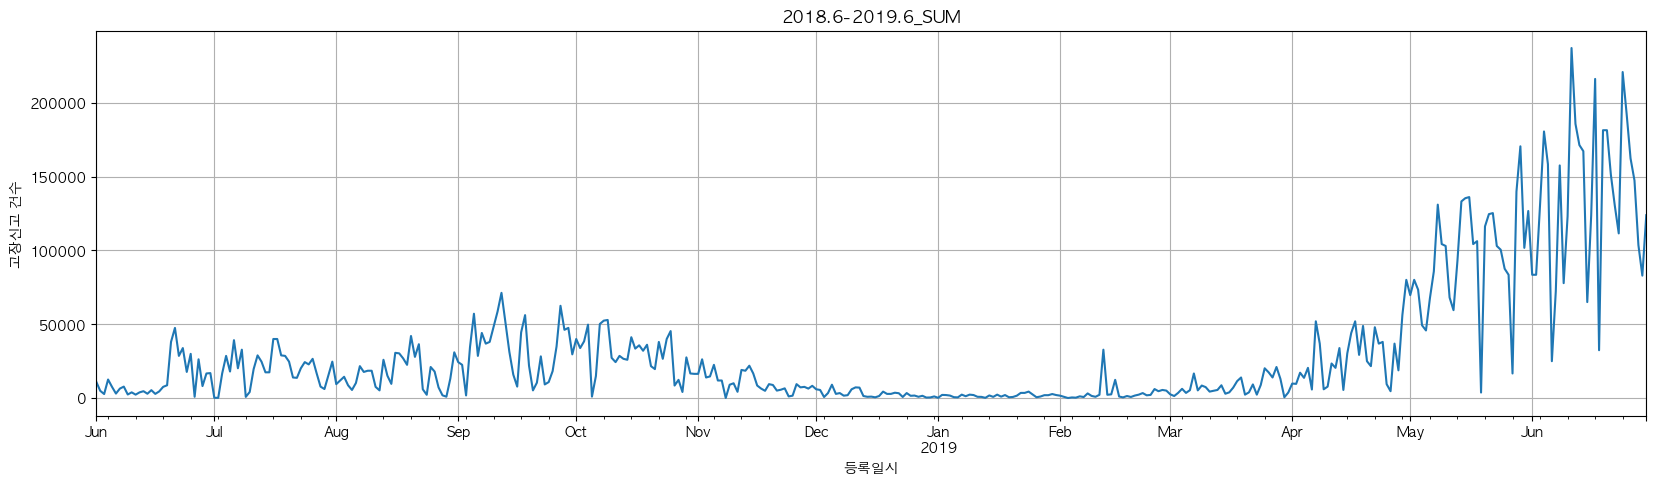

In [68]:
#2018.6~2019.6 고장구분 sum 시각화
rc('font', family='AppleGothic')
plt.title("2018.6-2019.6_SUM")#데이터_고장구분
plt.xlabel("날짜")
plt.ylabel("고장신고 건수")
data_sum["2018-6":"2019-6"].plot(figsize=(20, 5), grid=True)

<AxesSubplot: title={'center': '2019.6-2020.6_SUM'}, xlabel='등록일시', ylabel='고장신고 건수'>

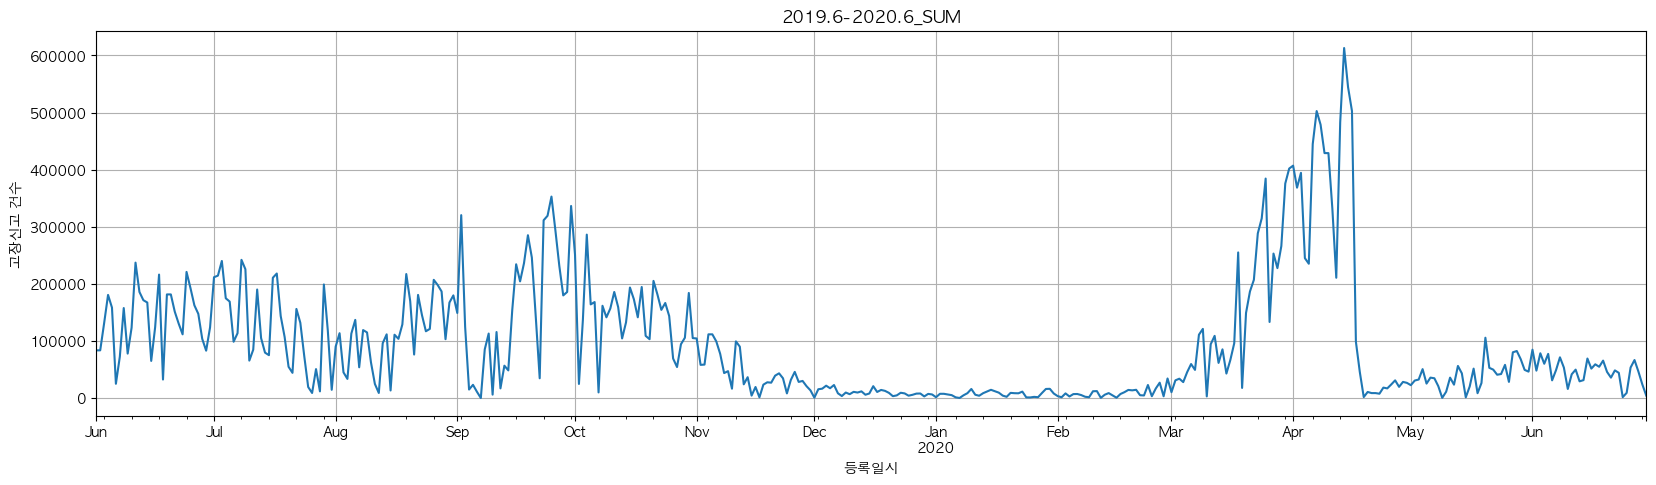

In [69]:
#2019.6~2020.6 고장구분 sum 시각화
rc('font', family='AppleGothic')
plt.title("2019.6-2020.6_SUM")#데이터_고장구분
plt.xlabel("날짜")
plt.ylabel("고장신고 건수")
data_sum["2019-6":"2020-6"].plot(figsize=(20, 5), grid=True)

<AxesSubplot: title={'center': '2020.6-2021.6_SUM'}, xlabel='등록일시', ylabel='고장신고 건수'>

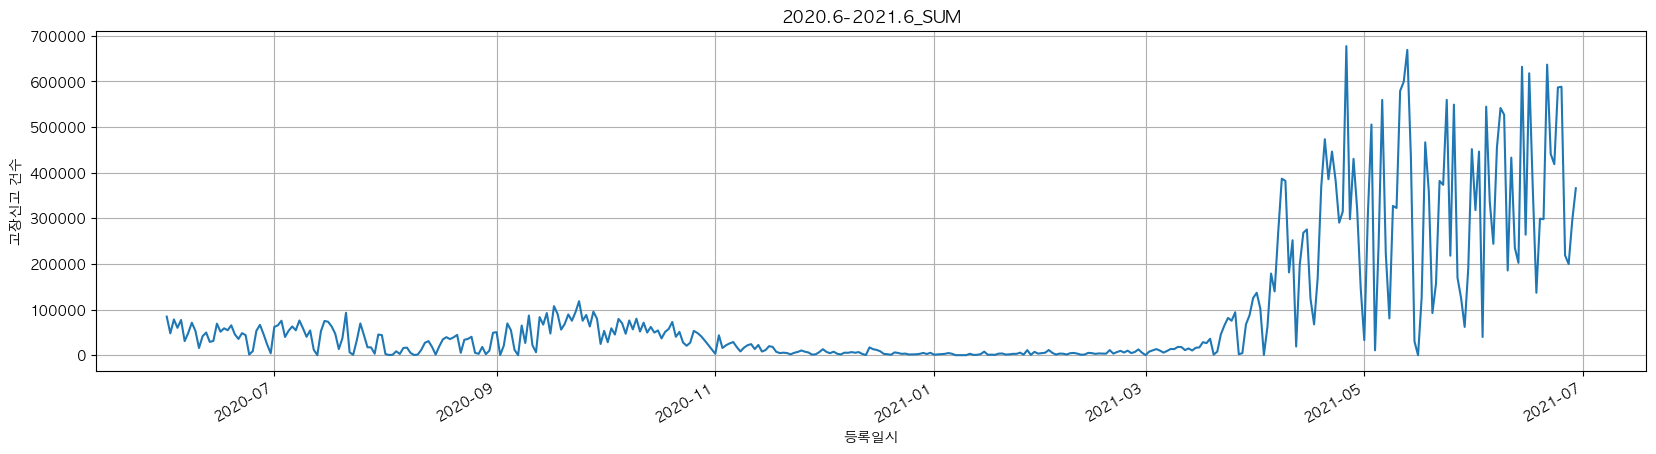

In [70]:
#고장신고가 증가하기 시작한 2020.6~2021.6 고장구분 sum 시각화
rc('font', family='AppleGothic')
plt.title("2020.6-2021.6_SUM")#데이터_고장구분
plt.xlabel("날짜")
plt.ylabel("고장신고 건수")
data_sum["2020-6":"2021-6"].plot(figsize=(20, 5), grid=True)

<AxesSubplot: title={'center': '2021.6-2022.6_SUM'}, xlabel='등록일시', ylabel='고장신고 건수'>

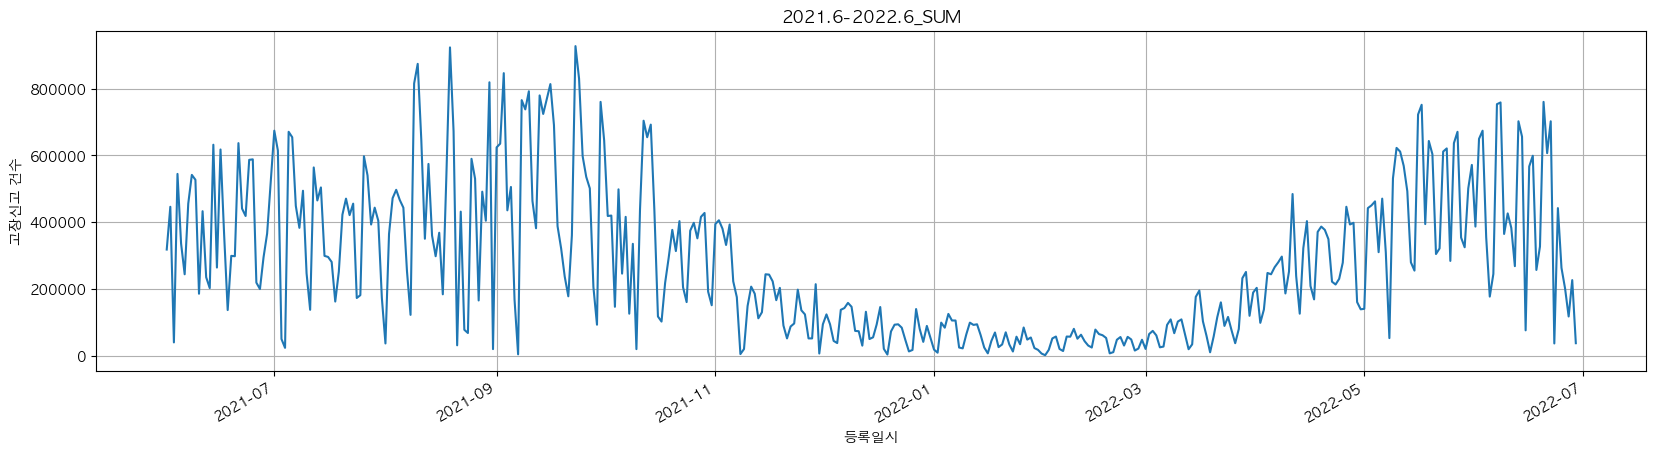

In [71]:
#고장신고가 증가하기 시작한 2021.6부터 전체 고장구분 sum 시각화
rc('font', family='AppleGothic')
plt.title("2021.6-2022.6_SUM")#데이터_고장구분
plt.xlabel("날짜")
plt.ylabel("고장신고 건수")
data_sum["2021-6":].plot(figsize=(20, 5), grid=True)

<AxesSubplot: title={'center': '2020.6-2022.6_SUM'}, xlabel='등록일시', ylabel='고장신고 건수'>

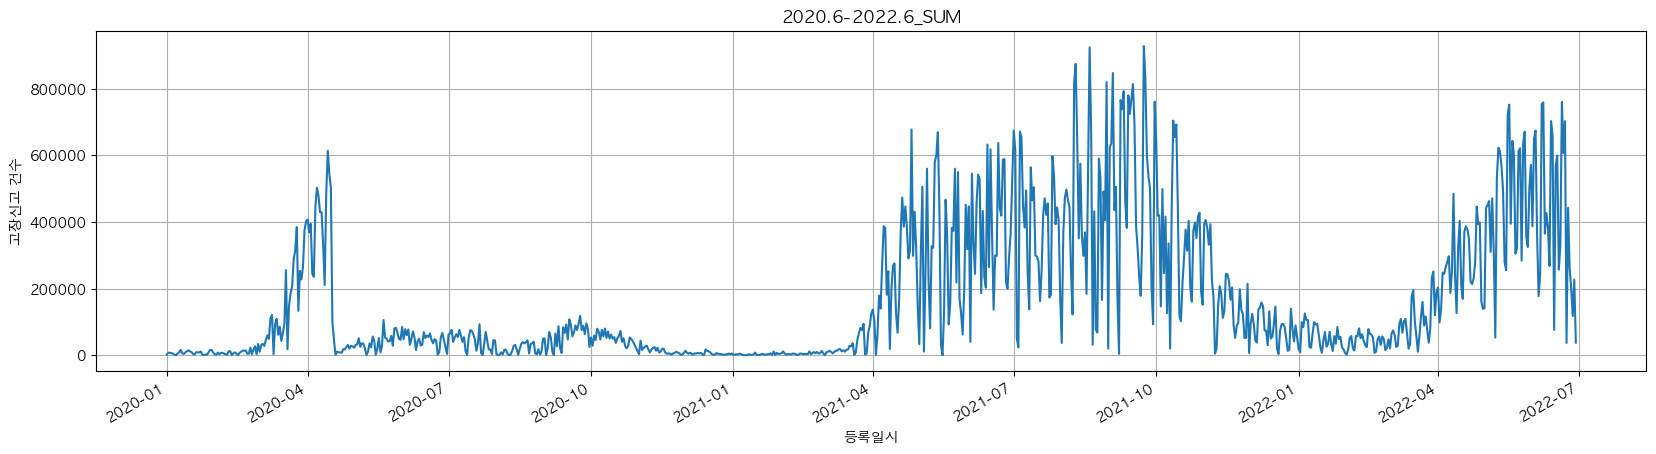

In [18]:
#고장신고가 증가하기 시작한 2020.6~2022.6 고장구분 sum 시각화
rc('font', family='AppleGothic')
plt.title("2020.6-2022.6_SUM")#데이터_고장구분
plt.xlabel("날짜")
plt.ylabel("고장신고 건수")
data_sum["2020-1":].plot(figsize=(20, 5), grid=True)

### 2-2. Visualize by month

In [72]:
#년, 월별 그룹바이
data_month = data
data_month["등록월"] = data["등록일시"].dt.month

In [73]:
#필요 column 추출 후, 등록월로 index 전환
data_month_idx = data[["등록월", "고장구분"]]
data_month_idx.set_index("등록월", inplace=True)
data_month_idx.head()

,고장구분
등록월,
12,체인
12,체인
12,기타
12,기타
12,기타


In [74]:
#등록월별로 groupby 후 고장구분 count => 같은 날짜, 다른 고장 구분 안합쳐짐
data_month_idx["c"]=data_month_idx.groupby("등록월").고장구분.count()
data_month_idx.head()

/var/folders/qy/_42009_n085fc984bjdc5v580000gn/T/ipykernel_94586/2453648831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_month_idx["c"]=data_month_idx.groupby("등록월").고장구분.count()


,고장구분,c
등록월,,
12,체인,15038
12,체인,15038
12,기타,15038
12,기타,15038
12,기타,15038


In [75]:
#data/고장구분 고장신고 count df 생성
data_month_type = data_month_idx.groupby(["등록월", "고장구분"]).c.sum().unstack()
data_month_type.head()

고장구분,기타,단말기,안장,잠금장치 불량,체인,타이어,파손,페달
등록월,,,,,,,,
1,48015296,18017692,20516496,11956,27761832,19691532,95648,8835484
2,44969349,17481075,20369751,22926,22627962,17756187,103167,8069952
3,188710167,171071127,114267906,330732,126229380,107901315,826830,50271264
4,583823820,377127540,372875120,1481180,450613180,321511620,2532340,172963600
5,760142250,326119500,495658800,2356200,603133650,444143700,5462100,230586300


In [76]:
#date별 전체 고장 건수 합
data_month_type["sum"]  = data_month_type.sum(axis=1)
data_month_type.head()

고장구분,기타,단말기,안장,잠금장치 불량,체인,타이어,파손,페달,sum
등록월,,,,,,,,,
1,48015296,18017692,20516496,11956,27761832,19691532,95648,8835484,142945936
2,44969349,17481075,20369751,22926,22627962,17756187,103167,8069952,131400369
3,188710167,171071127,114267906,330732,126229380,107901315,826830,50271264,759608721
4,583823820,377127540,372875120,1481180,450613180,321511620,2532340,172963600,2282928400
5,760142250,326119500,495658800,2356200,603133650,444143700,5462100,230586300,2867602500


In [77]:
#float -> int 변경
data_month_type=data_month_type.astype(int)
data_month_type.head()

고장구분,기타,단말기,안장,잠금장치 불량,체인,타이어,파손,페달,sum
등록월,,,,,,,,,
1,48015296,18017692,20516496,11956,27761832,19691532,95648,8835484,142945936
2,44969349,17481075,20369751,22926,22627962,17756187,103167,8069952,131400369
3,188710167,171071127,114267906,330732,126229380,107901315,826830,50271264,759608721
4,583823820,377127540,372875120,1481180,450613180,321511620,2532340,172963600,2282928400
5,760142250,326119500,495658800,2356200,603133650,444143700,5462100,230586300,2867602500


In [78]:
#전체 합만 가지고 있는 df 생성
data_month_sum = data_month_type["sum"]

<AxesSubplot: title={'center': '월별 고장신고'}, xlabel='등록월', ylabel='고장신고 건수'>

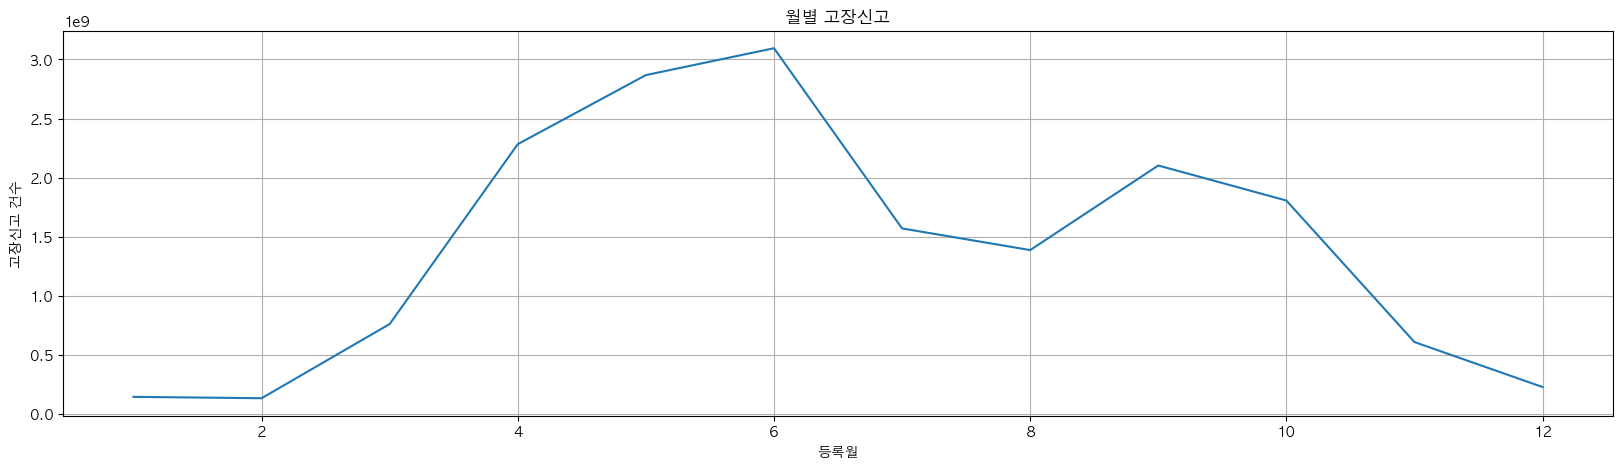

In [108]:
#전체 데이터 고장구분 sum 시각화
rc('font', family='AppleGothic')
plt.title("월별 고장신고")#데이터_고장구분
plt.xlabel("날짜")
plt.ylabel("고장신고 건수")
data_month_sum.plot(figsize=(20, 5), grid=True)

### 3. Time Series Analysis(Fault Type)

In [80]:
#위에서 생성한 등록일시/고장구분 데이터에서 불필요한 sum 제거
data_type=data_type.drop("sum", axis=1)

<AxesSubplot: xlabel='등록일시'>

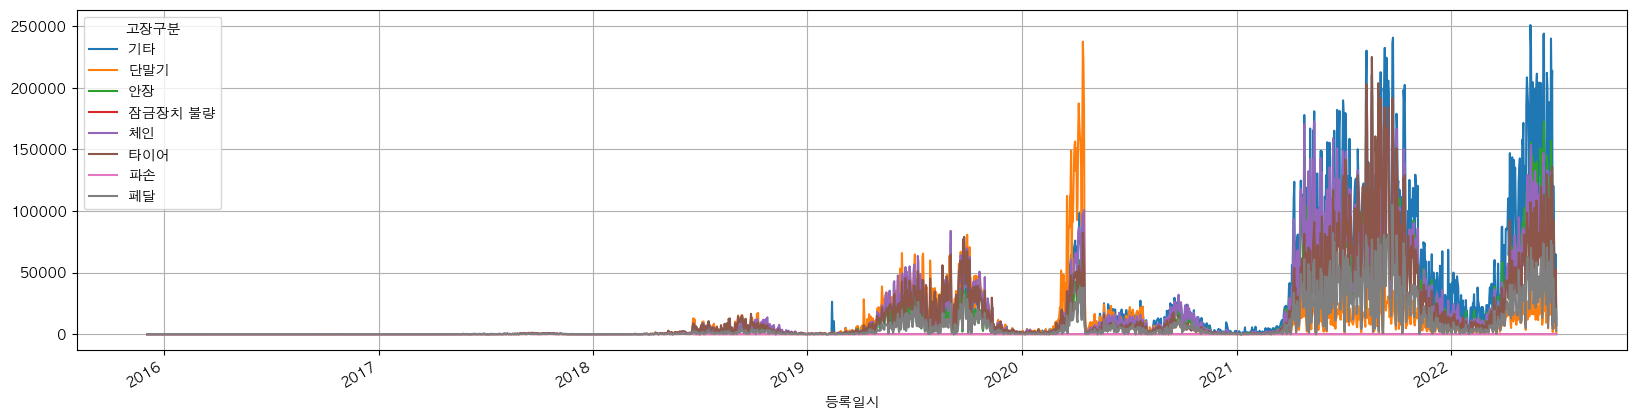

In [100]:
rc('font', family='AppleGothic')
data_type.plot(figsize=(20, 5), grid=True)

<AxesSubplot: xlabel='등록일시'>

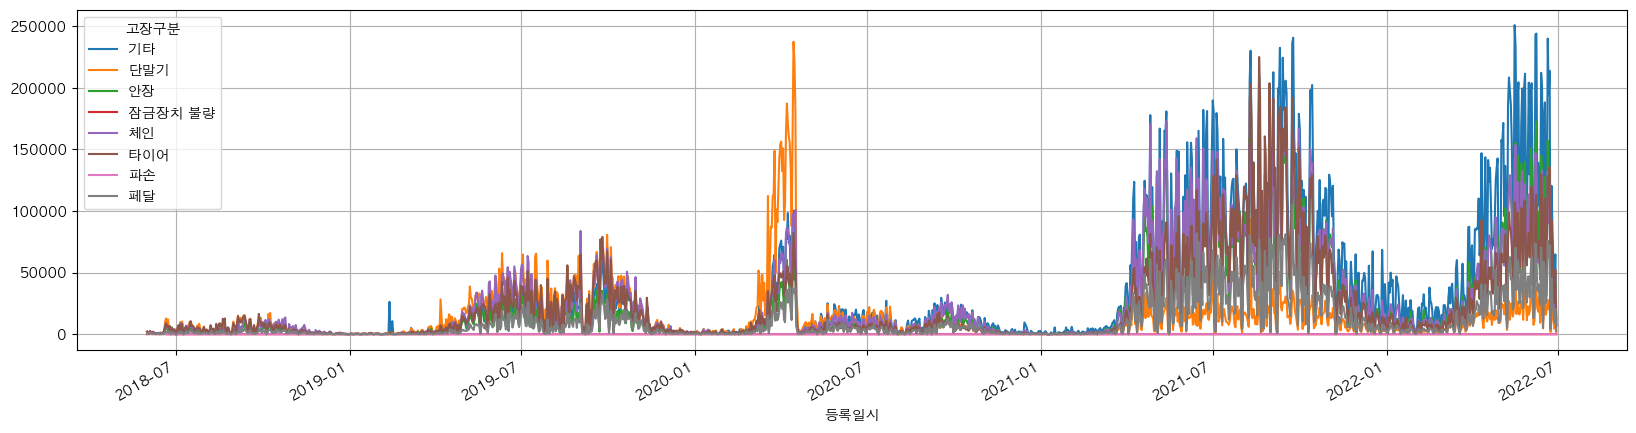

In [101]:
#고장신고가 증가하기 시작한 2018.6부터 전체 고장구분 sum 시각화
rc('font', family='AppleGothic')
data_type["2018-6":].plot(figsize=(20, 5), grid=True)

In [83]:
#더 자세한 확인을 위해 1년 단위로 시각화

<AxesSubplot: xlabel='등록일시'>

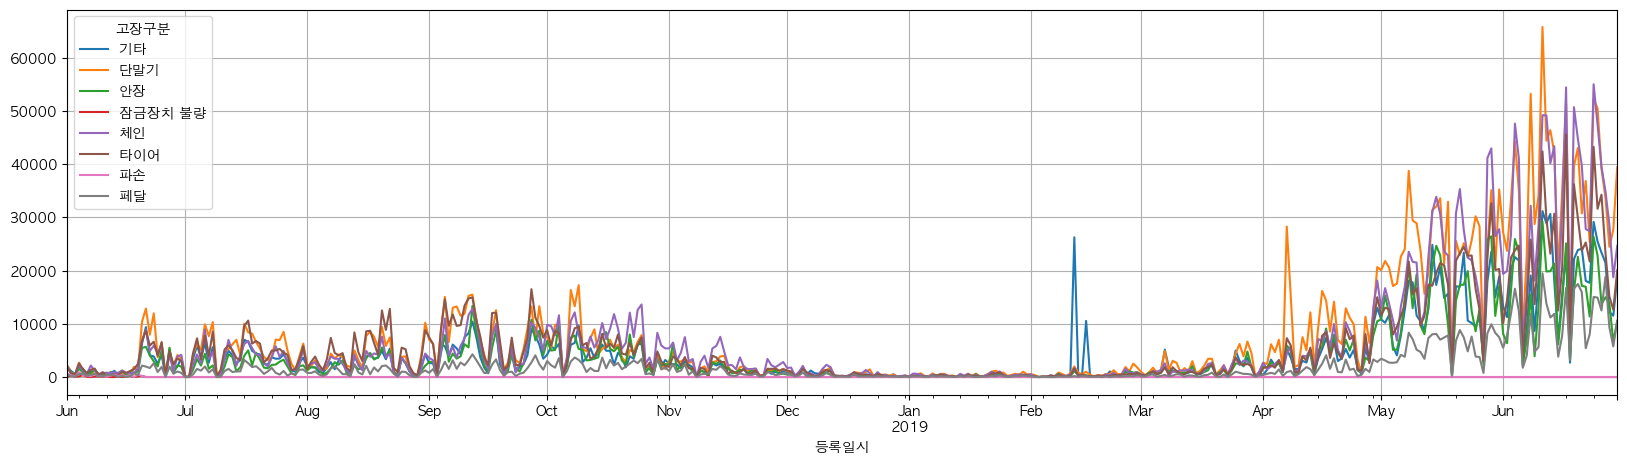

In [102]:
#2018.6~2019.6 고장구분 sum 시각화
rc('font', family='AppleGothic')
data_type["2018-6":"2019-6"].plot(figsize=(20, 5), grid=True)

<AxesSubplot: xlabel='등록일시'>

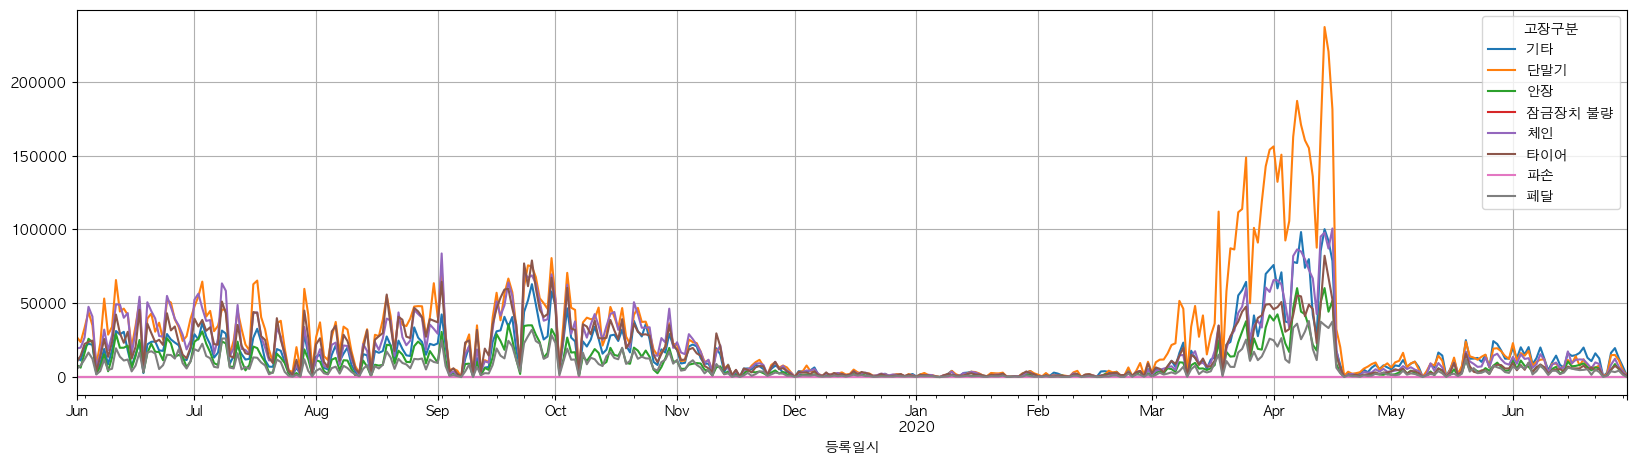

In [103]:
#2019.6~2020.6 고장구분 sum 시각화
rc('font', family='AppleGothic')
data_type["2019-6":"2020-6"].plot(figsize=(20, 5), grid=True)

<AxesSubplot: xlabel='등록일시'>

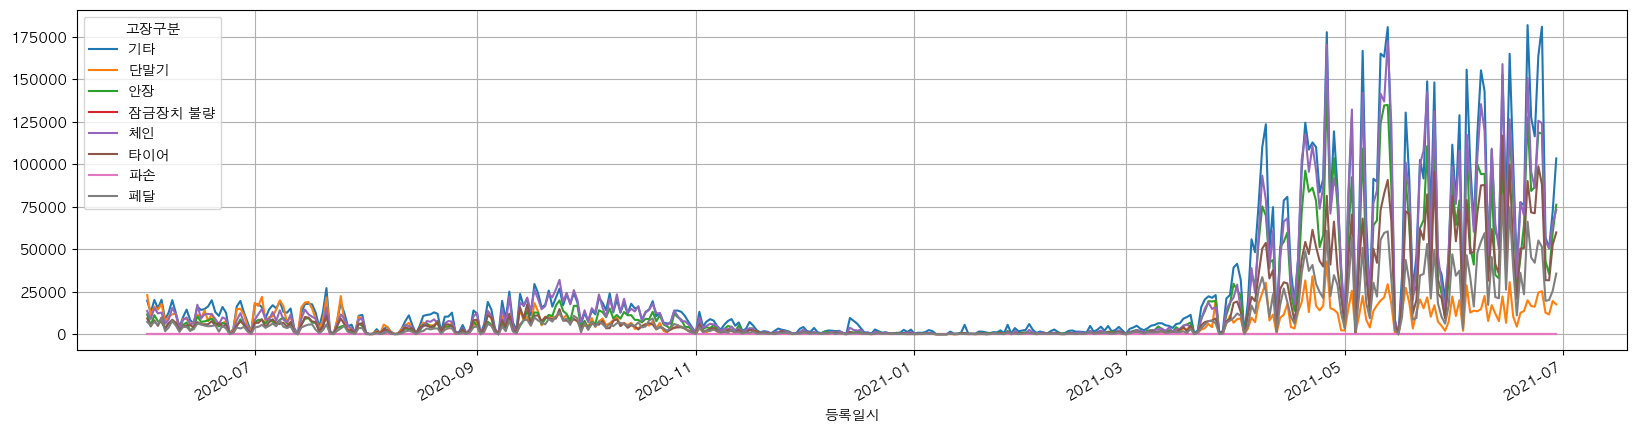

In [104]:
#2020.6~2021.6 고장구분 sum 시각화
rc('font', family='AppleGothic')
data_type["2020-6":"2021-6"].plot(figsize=(20, 5), grid=True)

<AxesSubplot: xlabel='등록일시'>

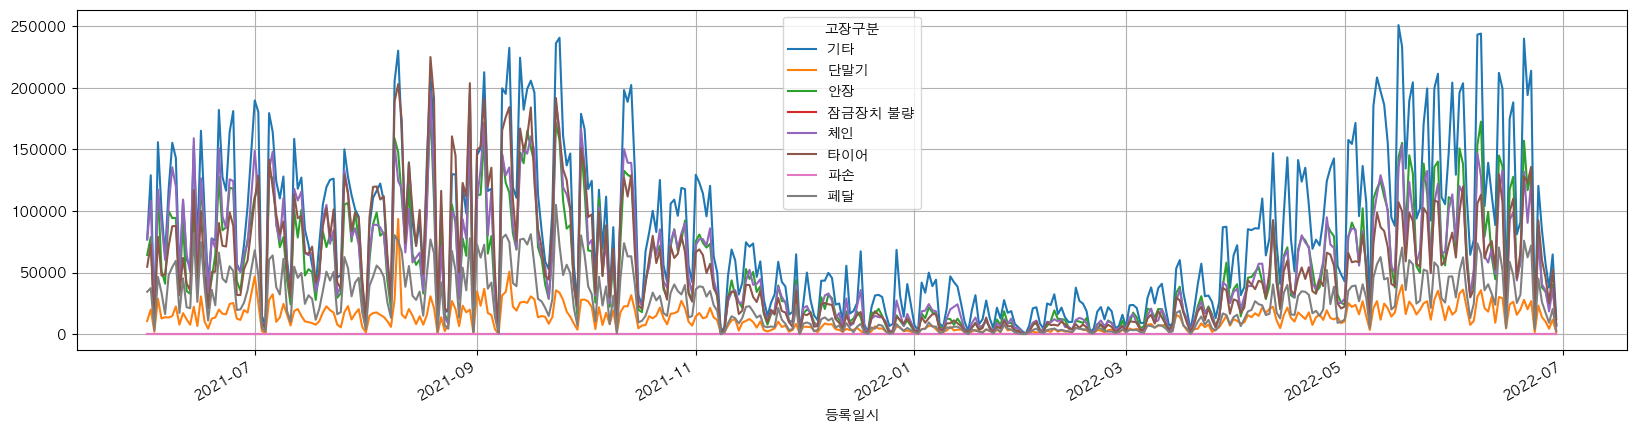

In [105]:
#2021.6~2022.6 고장구분 sum 시각화
rc('font', family='AppleGothic')
data_type["2021-6":"2022-6"].plot(figsize=(20, 5), grid=True)

### 3-1. Visualize by month

In [89]:
#불필요한 column 제거
data_month_type=data_month_type.drop("sum", axis=1)
data_month_type

고장구분,기타,단말기,안장,잠금장치 불량,체인,타이어,파손,페달
등록월,,,,,,,,
1,48015296,18017692,20516496,11956,27761832,19691532,95648,8835484
2,44969349,17481075,20369751,22926,22627962,17756187,103167,8069952
3,188710167,171071127,114267906,330732,126229380,107901315,826830,50271264
4,583823820,377127540,372875120,1481180,450613180,321511620,2532340,172963600
5,760142250,326119500,495658800,2356200,603133650,444143700,5462100,230586300
6,779432340,355501260,514169428,1780288,646912152,515727180,5785936,275833372
7,346019555,245283696,224328419,356517,316587096,307555332,1228003,127831151
8,290303944,194144020,200026044,856244,254974572,332855548,2010312,110753300
9,464944568,276967768,305806160,1650528,427715992,444221272,3988776,176744040


<AxesSubplot: xlabel='등록월'>

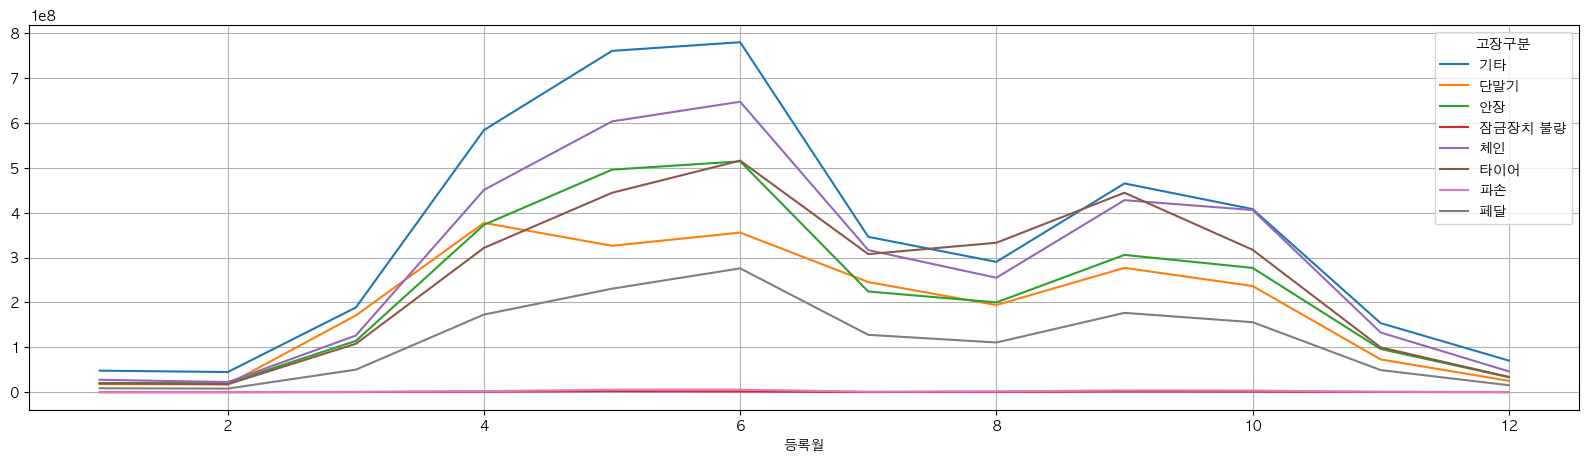

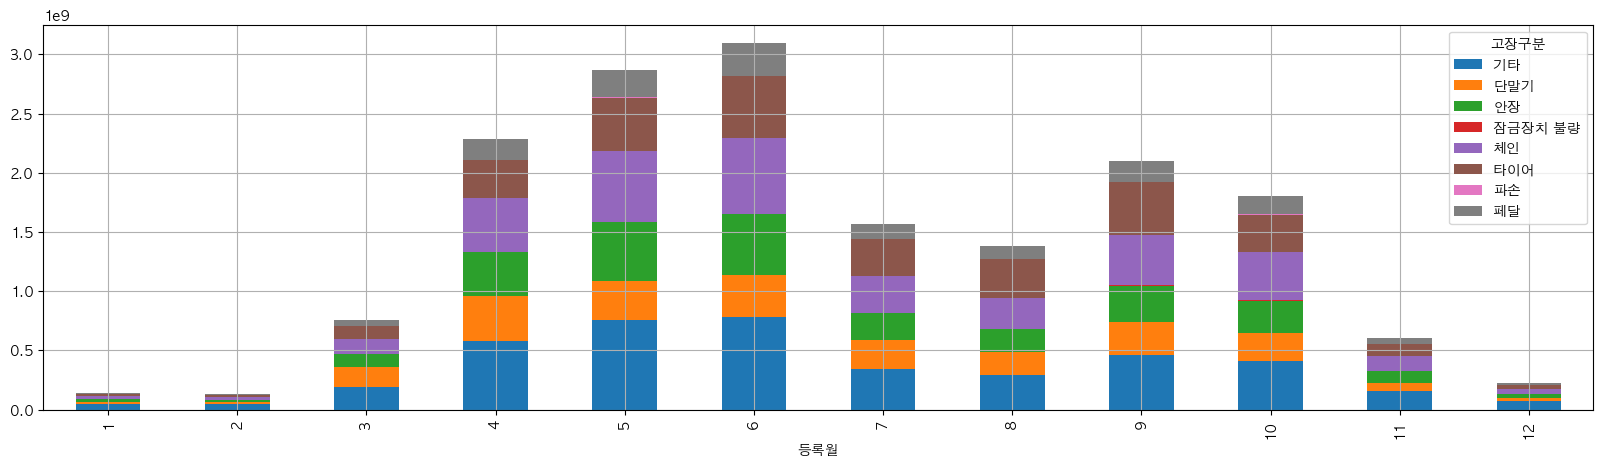

In [97]:
#전체 데이터 고장구분 시각화
rc('font', family='AppleGothic')
data_month_type.plot(figsize=(20, 5), grid=True)
data_month_type.plot(kind="bar", stacked=True, figsize=(20,5), grid=True)